<a href="https://colab.research.google.com/github/OurCultureBangkit/machine_learning/blob/main/ourculture_model/ourCulture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from PIL import Image

In [3]:
pip install split-folders[full]

In [23]:
import splitfolders
input_folder = '/content/drive/MyDrive/dataset'

splitfolders.ratio(input_folder, output='ourculture',
                    seed=42, ratio=(.8, .2),
                    group_prefix=None)

Copying files: 2654 files [00:29, 89.26 files/s]


In [26]:
train_dir = '/content/ourculture/train'
val_dir = '/content/ourculture/val'

In [27]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    class_mode='categorical')
valid_generator = val_datagen.flow_from_directory(val_dir,
                                                  target_size=(150,150),
                                                  class_mode='categorical')

Found 2110 images belonging to 30 classes.
Found 528 images belonging to 30 classes.


In [28]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
  layer.trainable=False

In [29]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_100[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [30]:
last_layer = base_model.get_layer('mixed7')

In [31]:
len(os.listdir(train_dir))

30

In [32]:
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(last_layer.output)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (2, 2), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(30, activation='softmax')(x)

model = Model(base_model.input, x)

In [33]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_100[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalization_94

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
history = model.fit(train_generator, epochs=50, validation_data=valid_generator)

Epoch 1/50
66/66 [==============================] - 153s 1s/step - loss: 2.2866 - accuracy: 0.2886 - val_loss: 1.1122 - val_accuracy: 0.6061
Epoch 2/50
66/66 [==============================] - 86s 1s/step - loss: 0.9670 - accuracy: 0.6526 - val_loss: 0.6891 - val_accuracy: 0.7424
Epoch 3/50
66/66 [==============================] - 85s 1s/step - loss: 0.6840 - accuracy: 0.7536 - val_loss: 0.6270 - val_accuracy: 0.7822
Epoch 4/50
66/66 [==============================] - 91s 1s/step - loss: 0.5491 - accuracy: 0.8043 - val_loss: 0.5631 - val_accuracy: 0.8239
Epoch 5/50
66/66 [==============================] - 83s 1s/step - loss: 0.4314 - accuracy: 0.8374 - val_loss: 0.5311 - val_accuracy: 0.8333
Epoch 6/50
66/66 [==============================] - 85s 1s/step - loss: 0.3879 - accuracy: 0.8559 - val_loss: 0.4719 - val_accuracy: 0.8542
Epoch 7/50
66/66 [==============================] - 84s 1s/step - loss: 0.3465 - accuracy: 0.8763 - val_loss: 0.4273 - val_accuracy: 0.8807
Epoch 8/50
66/66 [=

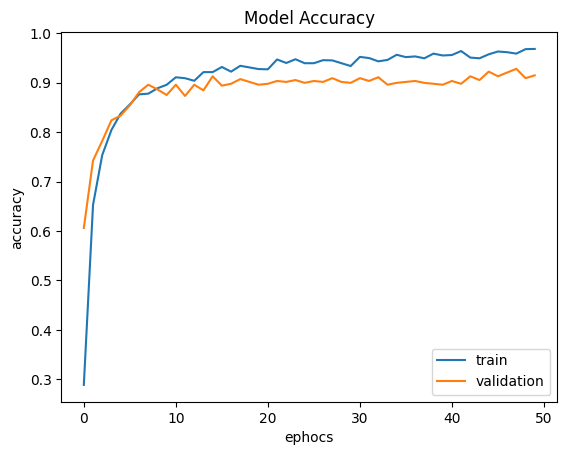

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

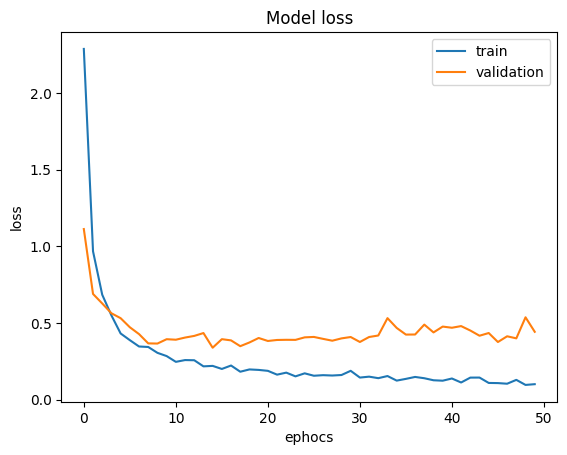

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('ephocs')
plt.legend(['train', 'validation'])
plt.show()

In [60]:
pred=[]
y_true=[]
total=0
folder =os.listdir(val_dir)
for files_dir in folder:
  files=os.listdir(val_dir+"/"+files_dir)
  for file in files:
    image = Image.open(val_dir + "/" + files_dir + "/"+file).convert('RGB')
    image = image.resize((150,150))
    image = np.expand_dims(image, axis=0)
    image = np.array(image)
    image = image/255
    pred.append(np.argmax(model.predict([image])[0]))
    y_true.append(total)
  total+=1

1/1 [==============================] - 0s 25ms/step


In [61]:
predictions = np.array(pred)
# binary_predictions = tf.argmax(predictions, axis=1)
np_true_y=np.array(y_true)
confusion_matrix_ = confusion_matrix(np_true_y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)

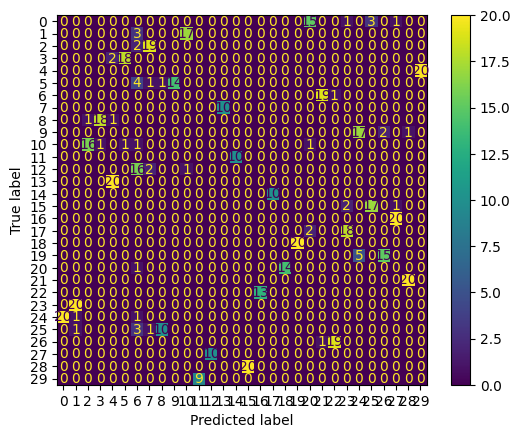

In [62]:
disp.plot()
plt.show()

In [45]:
# print(binary_predictions)
# print(valid_generator.classes)

tf.Tensor(
[11 24 12  5 21  2 24 29 18 27  0  8 16  1  7 22 17 21 25  9 16 25  6 28
 10  3  2 28  7 27 29  5  9  4 24  5 10  0 12 24 26 28  3  3 25 27 28  7
 10  9 28  5  9 15 25  0 19 19  1  7  0 28 19 21  1 22  4 21 29 16 28 20
 24 26 20 12  2 29 21 21 12  2 13 23 15 24 25 23 24 15 26 20  6  3 16 27
 20 27 22  6 23 27 19 24 13 24 26 21  7 22  3  7 26 19 19  0 19 26  5 11
 29 20  3  4 22  2  1 24 17 22 22 13  9  5  1 28 27 28 14 27  6 28  1 29
 11 25 23  4  7 26  8 18  7  9  7 15  8  6 29 20  1 29 19 27  8 27  8 17
 16  7  9  4 15 17 26  0 29 14 17 18  4  7 14  0 25  4 19 15 24  6  6 10
 19 26 20 23  3 22  2 22  7 25 29  5  0 22  4 16 27 19  7  0 25 22 14  2
 25 26 18 27 21 24  0  7 23 26 16 15 10 13  5  7 11  0  7 20  7  8 20 19
 25 18 20  0 15 24  4  2 27 22 22 13 27 26  1  8  1 18  6  5 14  5 17 19
 26  5 16  6 11  1  3  9 22  0 10 13 25 21  4 12  6 29  1 20 18 24  4 26
  9 27 27  0  1  9  4  8  9  6  0  3 10 23  6 22 24  2  3 15  4  6  9  4
 22 20  4 23  3  3 10 13 17 14  4 18 25 

In [ ]:
!mkdir -p ourCulture_model
model.save('ourculture_model/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
ourculture_model = "saved_model"

In [ ]:
tf.saved_model.save(model, ourculture_model)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(ourculture_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model.
with open('ourCulture_model/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!zip -r /content/ourCulture_model.zip /content/ourCulture_model

  adding: content/ourCulture_model/ (stored 0%)
  adding: content/ourCulture_model/model.tflite (deflated 17%)


In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

classes = ['Arit', 'Golok', 'Angkep Pala', 'Badong', 'Badong Kulit', 'Gelang Kana Kulit', 'Keris Cuntrik', 'Keris Lurus', 'Keris Lurus Batok Budo', 'Keris Luk Lima', 'keris Luk Sebelas',
           'Mask Bujuh', 'Mask Dalem', 'Mask Keras', 'Mask Penasar', 'Mask Sidakarya', 'Mask Tua', 'Mask Wijil', 'tombak',
           'Wayang Arjuna', 'Wayang Bagong', 'Wayang Bathara Surya', 'Wayang Bathara Wisnu', 'Wayang Gareng', 'Wayang Nakula', 'Wayang Petruk', 'Wayang Sadewa', 'Wayang Semar', 'Wayang Werkudara', 'Wayang Yudistira']

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = load_img(path, target_size=(150, 150))
  x = img_to_array(img) / 255.0
  x = np.expand_dims(x, axis=0)

  output = model.predict(x)
  best_index = np.argmax(output)
  print(fn)
  print(output)
  print(classes[best_index])

Saving WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg to WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg
1/1 [==============================] - 1s 1s/step
WhatsApp Image 2023-11-29 at 22.28.56_29119f9b.jpg
[[7.8745055e-10 7.4152080e-11 9.9118417e-03 4.3024966e-06 4.9460948e-07
  7.6676962e-08 1.1344004e-09 2.3488750e-10 4.4330246e-09 2.5681837e-07
  4.0512751e-03 2.3233126e-06 1.9770053e-07 7.6395135e-10 2.4804142e-10
  4.1615916e-03 9.8084396e-01 2.1078452e-09 4.2832805e-13 1.9003846e-07
  9.7470252e-07 2.6275848e-11 1.7451086e-11 6.0040057e-09 1.7708432e-07
  5.7495213e-09 5.7000475e-09 2.0622057e-08 1.0222752e-03 2.1848848e-08]]
Mask Tua


In [ ]:
for labels in classes:
  print(labels)
len(classes)

Arit
Golok
Angkep Pala
Badong
Badong Kulit
Gelang Kana Kulit
Keris Cuntrik
Keris Lurus
Keris Lurus Batok Budo
Keris Luk Lima
keris Luk Sebelas
Mask Bujuh
Mask Dalem
Mask Keras
Mask Penasar
Mask Sidakarya
Mask Tua
Mask Wijil
tombak
Wayang Arjuna
Wayang Bagong
Wayang Bathara Surya
Wayang Bathara Wisnu
Wayang Gareng
Wayang Nakula
Wayang Petruk
Wayang Sadewa
Wayang Semar
Wayang Werkudara
Wayang Yudistira


30